In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Data gathering


In [2]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip
     

TRAIN_DIR = "./cats_and_dogs_filtered/train"
VAL_DIR = "./cats_and_dogs_filtered/validation"

Inspect samples from datasets.



Image shape: (457, 491, 3)
Pixel in range: 0 255


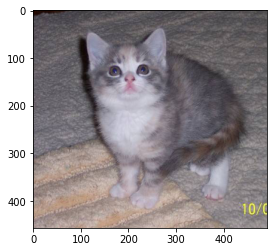

In [3]:
sample_idx = 0
label = "cats"
train_sample_fn = os.listdir(os.path.join(TRAIN_DIR, label))[sample_idx]
train_sample_path = os.path.join(TRAIN_DIR, label, train_sample_fn)

img = Image.open(train_sample_path)
img_data = np.asarray(img)

print("Image shape:", img_data.shape)
print("Pixel in range:", np.min(img_data), np.max(img_data))
plt.imshow(img_data);

Create TF datasets (with data augmentation in training)



In [4]:
IMG_SIZE = (224, 224)
INP_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

def gen_new_data(data_folder, augmented=True):
  if augmented:
    data_gen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
  else:
    data_gen = ImageDataGenerator(rescale=1./255)

  data = data_gen.flow_from_directory(
      data_folder,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode="binary",
  )
  return data
     

ds_train = gen_new_data(TRAIN_DIR, augmented=True)
ds_val = gen_new_data(VAL_DIR, augmented=False)
     

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Transfer learning


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing
 

ResNet-50

The default size of input image is 224 x 224, but not fixed.

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4" 

resnet = Sequential()
resnet.add(Resizing(224, 224, input_shape=INP_SHAPE))
resnet.add(hub.KerasLayer(resnet_url, trainable=False))
resnet.add(Dense(1, activation="sigmoid"))
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [7]:
resnet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

resnet_history = resnet.fit(ds_train, epochs=5, validation_data=ds_val)

Epoch 1/5
32/32 [==============================] - 48s 1s/step - loss: 0.2705 - acc: 0.8930 - val_loss: 0.0843 - val_acc: 0.9840
Epoch 2/5
32/32 [==============================] - 30s 944ms/step - loss: 0.0947 - acc: 0.9725 - val_loss: 0.0473 - val_acc: 0.9880
Epoch 3/5
32/32 [==============================] - 30s 926ms/step - loss: 0.0752 - acc: 0.9690 - val_loss: 0.0395 - val_acc: 0.9890
Epoch 4/5
32/32 [==============================] - 30s 934ms/step - loss: 0.0582 - acc: 0.9805 - val_loss: 0.0327 - val_acc: 0.9900
Epoch 5/5
32/32 [==============================] - 30s 930ms/step - loss: 0.0531 - acc: 0.9805 - val_loss: 0.0366 - val_acc: 0.9860


MobileNetV2

Size of input image is 224 x 224, fixed.

In [8]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

mobilenet = Sequential()
mobilenet.add(Resizing(224, 224, input_shape=INP_SHAPE))
mobilenet.add(hub.KerasLayer(mobilenet_url, trainable=False))
mobilenet.add(Dense(1, activation="sigmoid"))
mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
mobilenet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

mobilenet_history = mobilenet.fit(ds_train, epochs=5, validation_data=ds_val)

Epoch 1/5
32/32 [==============================] - 34s 928ms/step - loss: 0.3011 - acc: 0.8955 - val_loss: 0.1232 - val_acc: 0.9750
Epoch 2/5
32/32 [==============================] - 29s 893ms/step - loss: 0.1389 - acc: 0.9505 - val_loss: 0.0754 - val_acc: 0.9850
Epoch 3/5
32/32 [==============================] - 28s 878ms/step - loss: 0.0957 - acc: 0.9680 - val_loss: 0.0591 - val_acc: 0.9860
Epoch 4/5
32/32 [==============================] - 28s 889ms/step - loss: 0.0907 - acc: 0.9670 - val_loss: 0.0525 - val_acc: 0.9870
Epoch 5/5
32/32 [==============================] - 29s 908ms/step - loss: 0.0866 - acc: 0.9670 - val_loss: 0.0483 - val_acc: 0.9870
